In [1]:
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text

In [2]:
#importing module
df= pd.read_csv(r"C:\Users\HP\Desktop\py-master\ML\14_naive_bayes\spam.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
#gaining insight into the data
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
#counting the number of spam amd ham
df["Category"].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
#getting the percentange of each
747/4825
#the spam is 15% and the ham is 85%

0.15481865284974095

In [6]:
#balancing dataset between ham and spam
df_spam = df[df["Category"]== "spam"]
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df["Category"]=="ham"]
df_ham.shape

(4825, 2)

In [8]:
#downsampling the ham the same number as spam
df_ham_downsampling = df_ham.sample(df_spam.shape[0])

In [9]:
df_ham_downsampling.shape

(747, 2)

In [10]:
#concatenating the data
df_balance = pd.concat([df_ham_downsampling, df_spam])

In [11]:
df_balance.shape

(1494, 2)

In [12]:
df_balance['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [13]:
df_balance["Spam"] = df_balance["Category"].apply(lambda x:1 if x == "spam" else 0)

In [14]:
df_balance

,Category,Message,Spam
2837,ham,Nice.nice.how is it working?,0
1027,ham,Yes da. Any plm at ur office,0
2061,ham,I did. One slice and one breadstick. Lol,0
811,ham,S:)s.nervous &lt;#&gt; :),0
4334,ham,Y bishan lei... I tot ü say lavender?,0
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1


In [15]:
from sklearn.model_selection import train_test_split
x_train, x_text, y_train, y_text = train_test_split(df_balance["Message"], 
                                                    df_balance["Spam"], 
                                                    stratify=df_balance["Spam"])

In [16]:
print(x_train.shape, y_train.shape)

(1120,) (1120,)


In [17]:
print(x_text.shape, y_text.shape)

(374,) (374,)


In [18]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [19]:
def sentence_embedding(sentence):
    preprocessing_text = bert_preprocess(sentence)
    return bert_encoder(preprocessing_text)['pooled_output']

sentence_embedding([
    "500$ discount.hurry up",  
    "Bhavin, are you up for a volleybal game tomorrow?"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132726 , -0.8884572 , ..., -0.74748856,
        -0.7531473 ,  0.91964483],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.8584752 ,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [20]:
e = sentence_embedding([
    "Banana", 
    "grapes",
    "orange",
    "jeff bezos",
    "elon musk",
    "Tony Elumelu"]
)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]], [e[2]])

array([[0.9841548]], dtype=float32)

In [22]:
cosine_similarity([e[0]], [e[1]])

array([[0.9911088]], dtype=float32)

In [23]:
cosine_similarity([e[5]], [e[3]])

array([[0.97688055]], dtype=float32)

In [24]:
#bert layer
text = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text)
output = bert_encoder(preprocessed_text)['pooled_output']

In [25]:
#neural network layer 
l = tf.keras.layers.Dropout(0.1, name="dropout")(output)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
#using the imput and output to construe model
model = tf.keras.Model(inputs=[text], outputs=[l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [27]:
len(x_train)

1120

In [28]:
Metric = [
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Recall(name= "recall")
]

model.compile(optimizer="adam", loss= "binary_crossentropy", metrics= Metric)

In [30]:
model.fit(x_train, y_train, epochs = 5, verbose=2)

Epoch 1/5
35/35 - 399s - loss: 0.6659 - precision: 0.6078 - accuracy: 0.5991 - recall: 0.5589 - 399s/epoch - 11s/step
Epoch 2/5
35/35 - 401s - loss: 0.5130 - precision: 0.8276 - accuracy: 0.8223 - recall: 0.8143 - 401s/epoch - 11s/step
Epoch 3/5
35/35 - 362s - loss: 0.4264 - precision: 0.8584 - accuracy: 0.8705 - recall: 0.8875 - 362s/epoch - 10s/step
Epoch 4/5
35/35 - 363s - loss: 0.3795 - precision: 0.8915 - accuracy: 0.8929 - recall: 0.8946 - 363s/epoch - 10s/step
Epoch 5/5
35/35 - 369s - loss: 0.3465 - precision: 0.8883 - accuracy: 0.8911 - recall: 0.8946 - 369s/epoch - 11s/step


In [31]:
model.evaluate(x_text, y_text)

12/12 [==============================] - 118s 10s/step - loss: 0.3570 - precision: 0.8647 - accuracy: 0.9037 - recall: 0.9572


[0.35696661472320557,
 0.8647342920303345,
 0.903743326663971,
 0.9572192430496216]

In [34]:
y_predict = model.predict(x_text)
y_predict = y_predict.flatten()

12/12 [==============================] - 114s 10s/step


In [37]:
import numpy as np
y_predict = np.where(y_predict > 0.5, 1, 0)
y_predict

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_text, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       187
           1       0.86      0.96      0.91       187

    accuracy                           0.90       374
   macro avg       0.91      0.90      0.90       374
weighted avg       0.91      0.90      0.90       374



In [41]:
cnn = confusion_matrix(y_text, y_predict)
cnn

array([[159,  28],
       [  8, 179]], dtype=int64)

Text(20.72222222222222, 0.5, 'Truth')

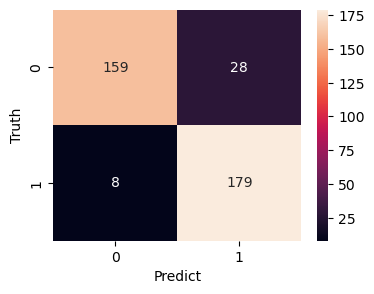

In [44]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize= [4,3])
sn.heatmap(cnn, annot=True, fmt="d"  )
plt.xlabel("Predict")
plt.ylabel("Truth")